In [ ]:
import torch
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# following: https://www.geeksforgeeks.org/time-series-forecasting-using-pytorch/

# Read data
T = 0.5
path = f"..\\data\\data_T{str(T)}.csv"
names = ['time', 'x1' , 'x2','obs_num']
df = pd.read_csv(path,sep=',', header=0, names=names,index_col=False)
print(df.head())
print(df.shape)

obs = max(df['obs_num'])
print("Number of different trajectory functions",int(obs))



In [ ]:
# Train test split

train_data = df[df['time']< (0.7 * T)]
test_data = df[df['time']>= (0.7 * T)]
print("train shape, test shape: ",train_data.shape, test_data.shape)
print(train_data.head())

train_times = df[df['time']< (0.7 * T)]["time"].tolist()
test_times =  df[df['time']>= (0.7 * T)]["time"].tolist()
print("train times: ", train_times)
print("test times: ", test_times)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1)) # StandardScaler() # 

# Scaling dataset
scaled_train = scaler.fit_transform(train_data.to_numpy())
scaled_train = pd.DataFrame(scaled_train, columns=names)
print(scaled_train.shape)
print(scaled_train.head())

scaled_test = scaler.fit_transform(test_data.to_numpy())
scaled_test = pd.DataFrame(scaled_test, columns=names)
print(scaled_test.shape)


In [4]:
# define positional encoding
# def positional_encoding(T, d_model):
#     # Initialize positional encoding matrix
#     t= np.linspace(0, 1, num=T)
#     pe = np.zeros((t.shape[0], d_model))
    
#     # Compute positional encodings
#     for pos, time in enumerate(t):
#         for i in range(d_model):
#             if i % 2 == 0:
#                 pe[pos, i] = np.sin(time / (10000 ** (2 * i / d_model)))
#             else:
#                 pe[pos, i] = np.cos(time / (10000 ** (2 * (i-1) / d_model)))
    
#     return np.array(pe)



# ## Save data
# ID = []
# PE = []
# d_model  = 1
# N = 10

# for i in range(N):
#     PE += [positional_encoding(T-1, d_model)[:,d_model-1]]

# PE = np.array(PE)
# print(PE)
# PE= PE.flatten()
# print(PE.shape)

In [5]:
# PE_train = PE[:training_data_len]
# PE_test  = PE[training_data_len:]

# scaled_train["u"] = scaled_train["u"] + PE_train
# scaled_train["dx_dt"] = scaled_train["dx_dt"] + PE_train

# scaled_test["u"] = scaled_test["u"] + PE_test
# scaled_test["dx_dt"] = scaled_test["dx_dt"] + PE_test

# print(scaled_train.head())
# print(scaled_test.head())

In [ ]:
# Create sequences
def to_sequences(seq_size, df, pred_len):
    x = []
    y = []
    times_x = []
    times_y = []
    
    overlap = 1 #seq_size - pred_len
    for obs in df['obs_num'].unique():
        df_obs = df[df['obs_num']==obs]
        obs_x1 = df_obs['x1'].tolist()
        obs_x2 = df_obs['x2'].tolist()
        t = df_obs['time'].tolist()
        for i in range((len(obs_x1))-seq_size-pred_len) : #create input and pred windows based on trajectory function
            
            window1 = obs_x1[i:(i+seq_size)]  # x at time t
            window2 = obs_x2[i:(i+seq_size)]  # u at time t
            t_x = t[i:(i+seq_size)]
        
            after_window1 = obs_x1[i+seq_size-overlap : i+seq_size+pred_len]  # delta x at time t+1 ( x_t+1 - x_t = delta_x_t+1)
            after_window2 = obs_x2[i+seq_size-overlap : i+seq_size+pred_len]
            t_y = t[i+seq_size-overlap : i+seq_size+pred_len]
            
            window = [[x, u] for x,u in zip(window1, window2)]
            after_window = [[x, u] for x,u in zip(after_window1, after_window2)]
            
            x.append(window)
            y.append(after_window)
            
            times_x.append(t_x)
            times_y.append(t_y)

    #return np.array(x).transpose((0,2,1)), np.array(y).transpose(0,2,1)
    return np.array(x), np.array(y), np.array(times_x), np.array(times_y)
pred_len =9
sequence_size = 10

X_train, y_train, X_train_times, y_train_times = to_sequences(sequence_size, scaled_train, pred_len)


# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

# Create sequences and labels for testing data
X_test,  y_test, X_test_times, y_test_times  = to_sequences(sequence_size, scaled_test, pred_len)
# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape, y_test.shape)

In [7]:
# from torch.utils.data import Dataset, DataLoader
# batch_size = 128
# class TimeSeriesDataset(Dataset):
#     def __init__(self, X, Y):
#         self.X = X
#         self.Y = Y

#     def __len__(self):
#         return len(self.X)

#     def __getitem__(self, idx):
#         return self.X[idx], self.Y[idx]

# train_dataset = TimeSeriesDataset(X_train, y_train)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    ## NB dropout layer is only applied during training not inference (https://keras.io/api/layers/regularization_layers/dropout/)
    
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    # x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    # x = layers.Dropout(dropout)(x)
    # x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1], activation="relu")(x)
    
    #x = layers.Conv2D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    #x = layers.Dropout(dropout)(x)
    #x = layers.Conv2D(filters=inputs.shape[-1], kernel_size=1)(x)

    return x + res

In [9]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0.25,
    mlp_dropout=0.25,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    #x = layers.Dense(24)(x)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    #x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    #x = layers.GlobalAveragePooling2D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(2, activation="relu")(x)
    return keras.Model(inputs, outputs)

In [17]:
# model parameters:
model_params = {
    'input_shape': (sequence_size,2),
    'head_size':4,
    'num_heads': 1,
    'ff_dim': 10, #32
    'num_transformer_blocks': 1,
    'mlp_units': [24], #24
    'mlp_dropout': 0.05,
    'dropout': 0.05,
    'validation_split': 0.2,
    'epochs':4000,
    'batch_size': 128,
    'learning_rate': 1e-4
}

In [25]:
model = build_model(
    input_shape = model_params["input_shape"],
    head_size = model_params["head_size"],
    num_heads = model_params["num_heads"],
    ff_dim = model_params["ff_dim"],
    num_transformer_blocks = model_params['num_transformer_blocks'],
    mlp_units = model_params["mlp_units"],
    mlp_dropout = model_params["mlp_dropout"],
    dropout = model_params["dropout"],
)

model.compile(
    loss="mean_absolute_percentage_error",
    optimizer=keras.optimizers.Adam(learning_rate=model_params['learning_rate'])
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, \
    restore_best_weights=True)]

model.fit(
    X_train,
    y_train,
    validation_split = model_params["validation_split"],
    epochs = model_params["epochs"],
    batch_size = model_params["batch_size"],
    #callbacks=callbacks,
    shuffle=True,
)
model.evaluate(X_test, y_test) #, verbose=1)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 10, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 2)     │          4 │ input_layer_2[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 2)     │         46 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 10, 2)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 10, 2)     │          0 │ dropout_9[0][0],  │
│                     │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 2)     │          4 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 10, 10)    │         30 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 10, 10)    │          0 │ dense_8[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 10, 2)     │         22 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 10, 2)     │          0 │ dense_9[0][0],    │
│                     │                   │            │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 10, 24)    │         72 │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 10, 24)    │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 10, 2)     │         50 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 228 (912.00 B)

 Trainable params: 228 (912.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4000
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 87.3937 - val_loss: 87.9234
Epoch 2/4000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 86.9636 - val_loss: 87.4038
Epoch 3/4000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 86.3304 - val_loss: 86.8904
Epoch 4/4000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 85.5052 - val_loss: 86.3586
Epoch 5/4000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 85.0294 - val_loss: 85.8264
Epoch 6/4000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 84.3744 - val_loss: 85.2868
Epoch 7/4000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 83.8903 - val_loss: 84.7475
Epoch 8/4000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 83.4182 - val_loss: 84.2056
Epoch 9/4000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 82.5341 - val_loss: 83.6483
Epoch 10/4000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 82.0623 - val_loss: 83.0900
Epoch 11/4000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 81.4791 - val_loss: 82.5321
Epoch 12/4000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/s

24.787538528442383

In [33]:
name = 'TNN_traj_enc_1.keras'
model.save(name , overwrite=False)

In [32]:
output = model.predict(X_test)
print(output)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[[[0.75029373 0.74190056]
  [0.76304376 0.7290088 ]
  [0.775823   0.71584547]
  ...
  [0.8401109  0.6459582 ]
  [0.29308107 0.694682  ]
  [0.28447938 0.6767583 ]]

 [[0.7626027  0.7290344 ]
  [0.7753817  0.715871  ]
  [0.78818977 0.7024362 ]
  ...
  [0.2941064  0.6947497 ]
  [0.2855005  0.67682564]
  [0.27698612 0.6585804 ]]

 [[0.7747884  0.7159055 ]
  [0.78759634 0.70247054]
  [0.8004333  0.6887642 ]
  ...
  [0.28605157 0.6768623 ]
  [0.277537   0.65861696]
  [0.2691192  0.64005077]]

 ...

 [[0.5055605  0.4250333 ]
  [0.49956143 0.40959907]
  [0.49365887 0.3939368 ]
  ...
  [0.47364816 0.3097924 ]
  [0.47321063 0.2905271 ]
  [0.47264653 0.27292198]]

 [[0.4995686  0.40959933]
  [0.49366578 0.39393702]
  [0.48785934 0.37804678]
  ...
  [0.47321692 0.29052728]
  [0.472653   0.27292213]
  [0.47223574 0.2555027 ]]

 [[0.49367055 0.39393735]
  [0.4878641  0.378047  ]
  [0.48215398 0.36192867]
  ...
  [0.4726573  0.27292228]
  [0.47224012 0.25550276]


In [34]:
print(y_test.shape)
print(output.shape)


torch.Size([220, 10, 2])
(220, 10, 2)


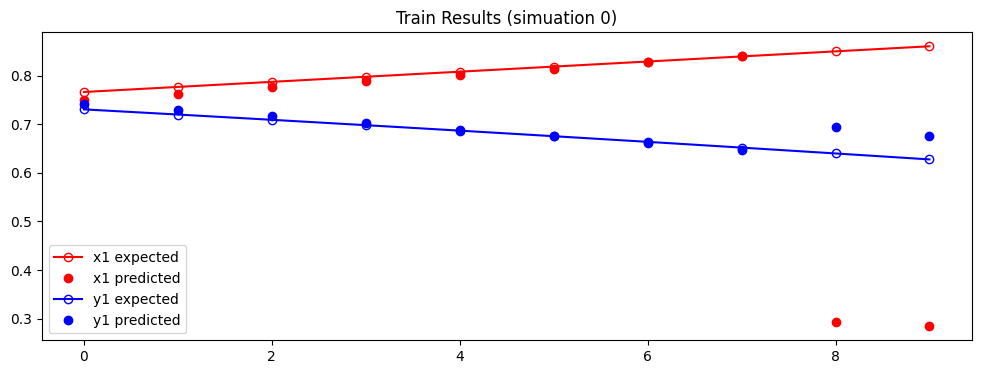

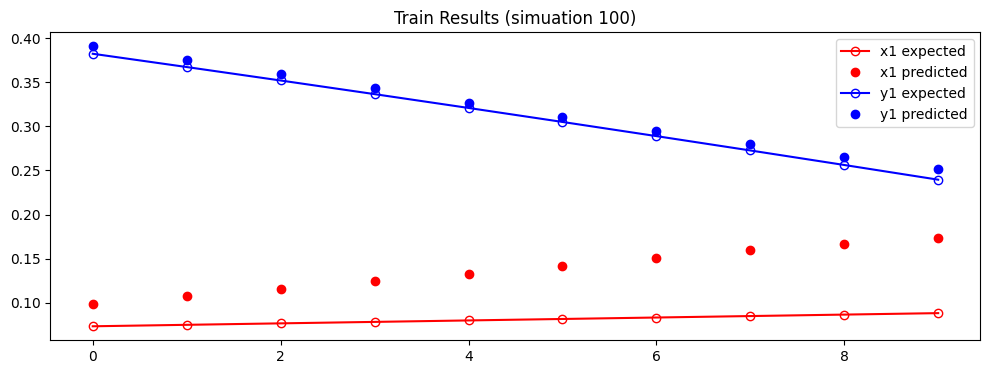

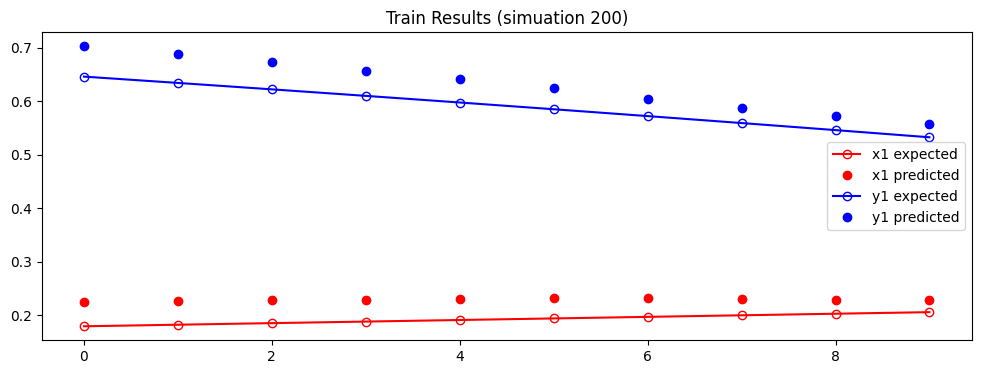

In [29]:
# display train results
import matplotlib.pyplot as plt

colours = ["r", "b", "g", "m", "c", "tab:orange", "tab:brown", "tab:pink", "tab:gray"]
data_files = ["x1", "y1"]
for i in [0, 100, 200]: # select batches
    for d, name in enumerate(data_files):
    
        plt.figure(i, figsize=(12, 4))
        plt.plot( y_test[i,:,d].detach().numpy(), "-o",fillstyle="none", color=colours[d], label=f'{name} expected')
        plt.plot( output[i,:,d] , "o", color=colours[d], label=f'{name} predicted')
        
        plt.title(f"Train Results (simuation {i})")
        plt.legend()

In [30]:

# # Evaluate the model
# model.eval()
# outputs = []
# with torch.no_grad():
#     output = model(X_test, X_test, sequence_size)
#     outputs += output
#     test_loss = criterion(output, y_test)
#     print(f'Test MSE Loss: {test_loss.item():.4f}')

# Evaluate the model
model.eval()
outputs = []
expected = []
avg_loss = 0 
with torch.no_grad():

    for b in range(X_test.shape[0]):   
        tgt = X_test[b, -1,:].unsqueeze(0) #overlap
        for i in range(pred_len+1):
            output = model(X_test[b,:,:], tgt, tgt.shape[0])
            # print(i, X_test.shape ,output.shape)
            tgt = torch.cat([tgt, output[ -1:, :]], dim=0)

        outputs += [output]
        expected += [targets]
        test_loss = criterion(output, y_test[b,:,:])
        avg_loss += test_loss.item()
    #print(f'Test MSE Loss: {test_loss.item():.4f}')

print("Average Loss: ", avg_loss/len(outputs))


AttributeError: 'Functional' object has no attribute 'eval'

In [ ]:
# #save model
model_path = ".\\toy_pytorch_model_3.pt"
torch.save(model.state_dict(), model_path)

In [ ]:
outputs = np.array(outputs)
print(y_test.shape, outputs.shape)
print(y_test_times.shape)

In [ ]:
# display test results
import matplotlib.pyplot as plt
for i in [0, 100, 250]:
    
    plt.figure(i, figsize=(6, 4))
    plt.plot(X_test_times[i,:], X_test[i,:,0], "-o", label='x input')
    plt.plot(y_test_times[i,:], y_test[i,:,0], "-o", label='x expected')
    plt.plot(y_test_times[i,:], outputs[i,:,0] , "x", label='x predicted')
    
    plt.plot(X_test_times[i,:], X_test[i,:,1], "-o", label='y input')
    plt.plot(y_test_times[i,:],y_test[i,:,1], "-o", label='y expected')
    plt.plot(y_test_times[i,:],outputs[i,:,1] , "x", label='y predicted')
    plt.title(f"Test Results TST on unseen data")
    plt.legend()

In [ ]:
from torchinfo import summary

print(summary(model, input_data=(X_test, X_test, sequence_size)))

In [ ]:
print("Transformer layers in order of connection:")
for name, layer in model.named_children():
    print(f"{name}: {layer}")

In [ ]:
print("All submodules in the transformer:")
for name, module in model.named_modules():
    print(f"{name}: {module}")